In [109]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import hvplot.xarray
%matplotlib inline

# Centre Voltage Sweep

In [72]:
cen_v= pd.read_csv('./2019-06-29/phi0_daedalus_voltCenter_calib_2019-06-29_2.csv', comment="#")

In [74]:
cen_v[abs(cen_v.Yfield-0.1)<0.001]

,V,Xfield,Yfield,Zfield,elapsed_time
320,-1.9,0.000122,0.100828,-0.000297,165.569872


In [75]:
cen_vp = cen_v[cen_v.Yfield>0]
cen_vn = cen_v[cen_v.Yfield<0]

In [76]:
cen_vp_coeff = np.polyfit(cen_vp.Yfield.values, cen_vp.V.values, 5)
cen_vn_coeff = np.polyfit(cen_vn.Yfield.values, cen_vn.V.values, 5)
cen_v_coeffs = np.asarray([cen_vp_coeff, cen_vn_coeff])
print(cen_v_coeffs)

[[ 4.16168895e+03 -3.11844226e+03  5.47011535e+02 -2.84592899e+01
  -1.86123341e+01  8.26244300e-03]
 [ 4.15146313e+03  3.09829665e+03  5.35103810e+02  2.63857442e+01
  -1.86952107e+01 -1.33786176e-02]]


In [82]:
np.savetxt("./icarusCalibCsv/icarus_volt_center_calib.csv", cen_v_coeffs, delimiter=",")

In [78]:
cen_vp_fit = np.poly1d(cen_vp_coeff)
cen_vn_fit = np.poly1d(cen_vn_coeff)

In [79]:
cen_vp_fit(0.1)

-1.8607796688426999

<IPython.core.display.Javascript object>


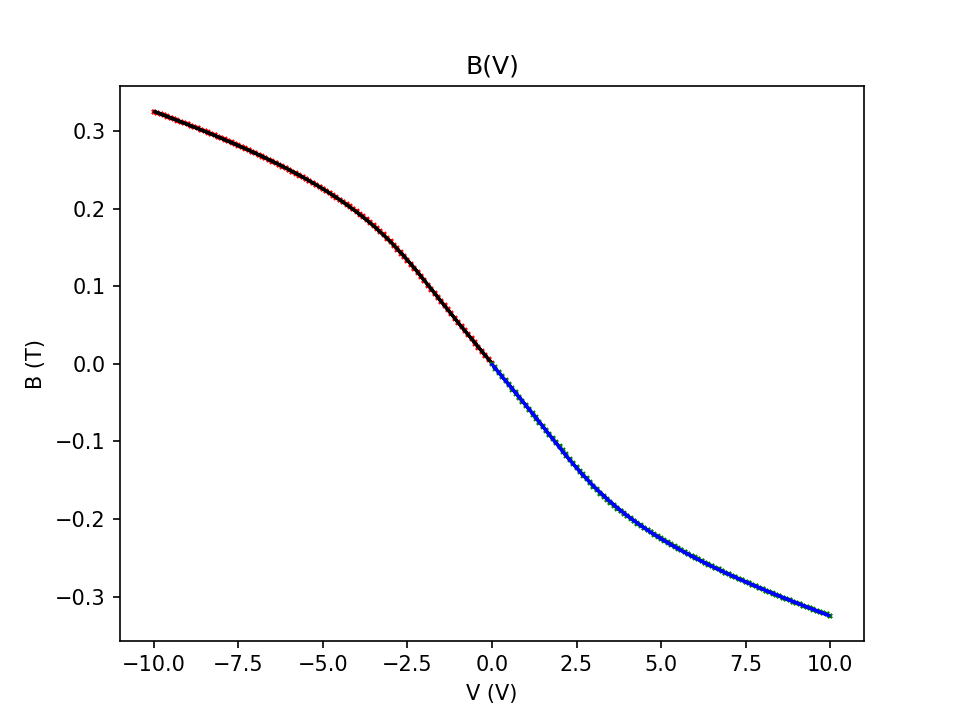

Text(0.5, 1.0, 'B(V)')

In [81]:
plt.figure(dpi=100)

plt.plot(cen_vp.V, cen_vp.Yfield, 'rx', markersize=2)
plt.plot(cen_vp_fit(cen_vp.Yfield), cen_vp.Yfield , 'k')

plt.plot(cen_vn.V, cen_vn.Yfield, 'gx', markersize=2)
plt.plot(cen_vn_fit(cen_vn.Yfield), cen_vn.Yfield , 'b')
plt.xlabel('V (V)')
plt.ylabel('B (T)')
plt.title('B(V)')

# Radial Calibration 5 V

In [83]:
vp = pd.read_csv('./2019-06-29/test_daedalus_radialPolar_calib_A000.0_2019-06-29_6.csv', comment='#')
vn = pd.read_csv('./2019-06-29/test_daedalus_radialPolar_calib_A000.0_2019-06-29_7.csv', comment='#')

In [84]:
vp = vp.assign(phi=lambda a: np.arctan2(a.Xfield, a.Yfield)*180/np.pi)
vp = vp.assign(theta=lambda a: np.arctan2(a.Zfield, -a.Yfield)*180/np.pi)
vp = vp.assign(Bmag=lambda a: np.sqrt(a.Yfield**2 + a.Zfield**2))

vn = vn.assign(phi=lambda a: np.arctan2(a.Xfield, a.Yfield)*180/np.pi)
vn = vn.assign(theta=lambda a: np.arctan2(a.Zfield, a.Yfield)*180/np.pi)
vn = vn.assign(Bmag=lambda a: np.sqrt(a.Yfield**2 + a.Zfield**2))

In [85]:
vp_dv = {}
vn_dv = {}
for c in vp.columns[:]:
    vp_dv[c] = (["R"],vp[c])
    vn_dv[c] = (["R"],vn[c])
vp_ds = xr.Dataset(vp_dv)
vn_ds = xr.Dataset(vn_dv)

### OOP field

In [86]:
vp_ds.where(abs(vp_ds.theta) == abs(vp_ds.theta).min(), drop=True)

<xarray.Dataset>
Dimensions:       (R: 1)
Coordinates:
  * R             (R) float64 -5.329e-14
Data variables:
    Xfield        (R) float64 -0.0001705
    Yfield        (R) float64 -0.2249
    Zfield        (R) float64 0.0007305
    theta         (R) float64 0.1861
    phi           (R) float64 -180.0
    elapsed_time  (R) float64 245.1
    Bmag          (R) float64 0.2249

In [87]:
vp_ds.where(abs(vn_ds.theta-90.0) == abs(vn_ds.theta-90.0).min(), drop=True)

<xarray.Dataset>
Dimensions:       (R: 1)
Coordinates:
  * R             (R) float64 14.4
Data variables:
    Xfield        (R) float64 -0.005288
    Yfield        (R) float64 -0.0002951
    Zfield        (R) float64 -0.1368
    theta         (R) float64 -89.88
    phi           (R) float64 -93.19
    elapsed_time  (R) float64 422.2
    Bmag          (R) float64 0.1368

<IPython.core.display.Javascript object>


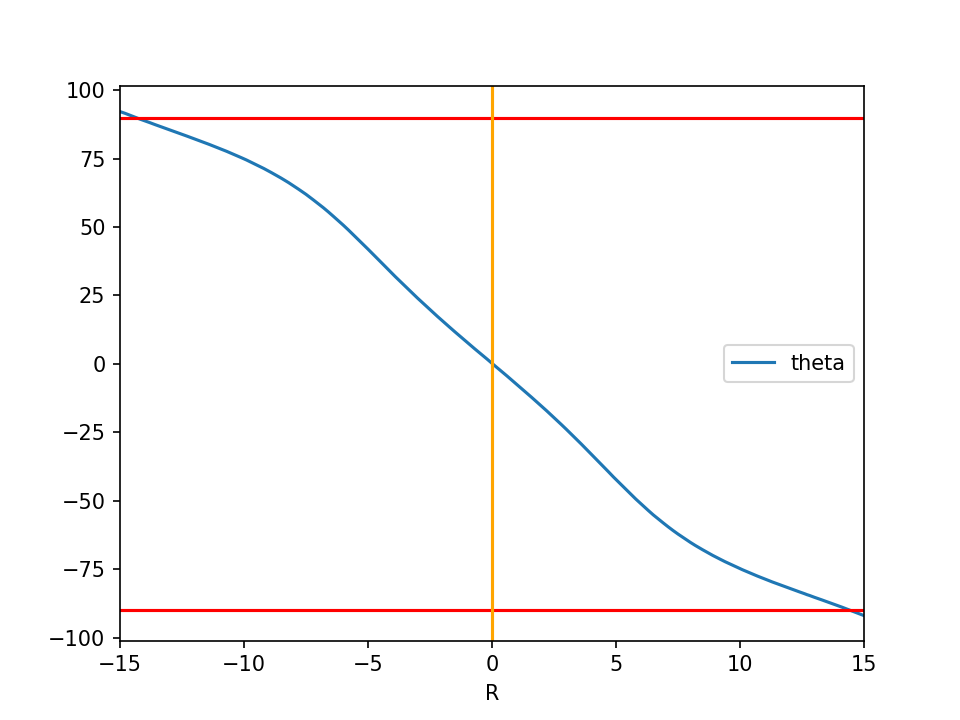

In [88]:
vp.plot('R', 'theta')
plt.axhline(90,color='r')
plt.axhline(-90,color='r')
plt.axvline(0,color='orange')

<IPython.core.display.Javascript object>


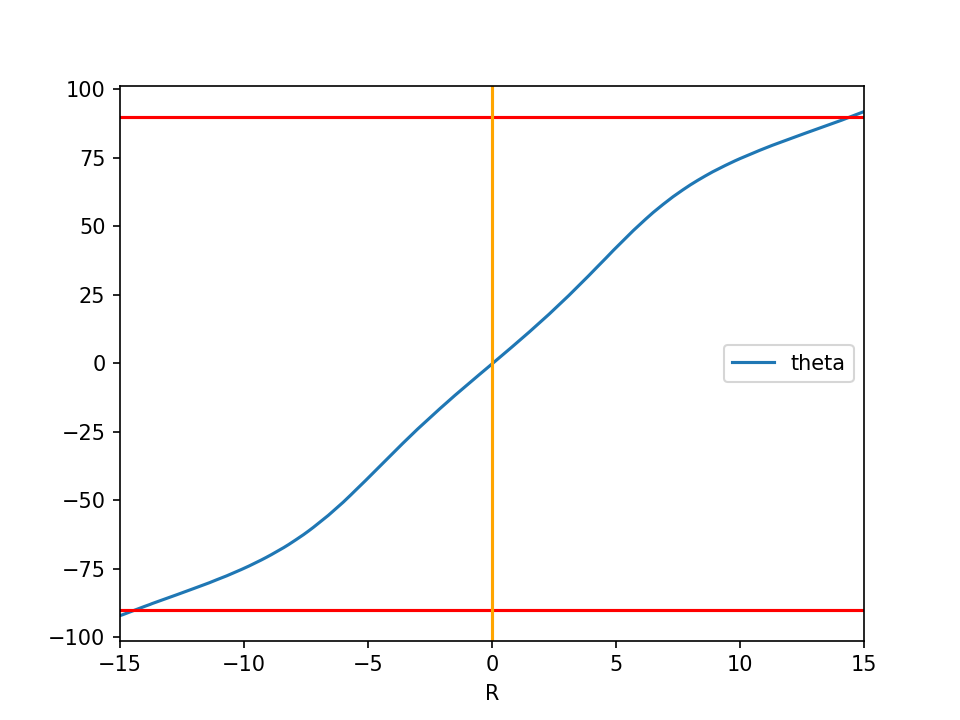

In [89]:
vn.plot('R', 'theta')
plt.axhline(-90,color='r')
plt.axhline(90, color='r')
plt.axvline(0,color='orange')

In [90]:
vp_rp = vp[vp.R>0]
vp_rn = vp[vp.R<0]
vn_rp = vn[vn.R>0]
vn_rn = vn[vn.R<0]

<IPython.core.display.Javascript object>


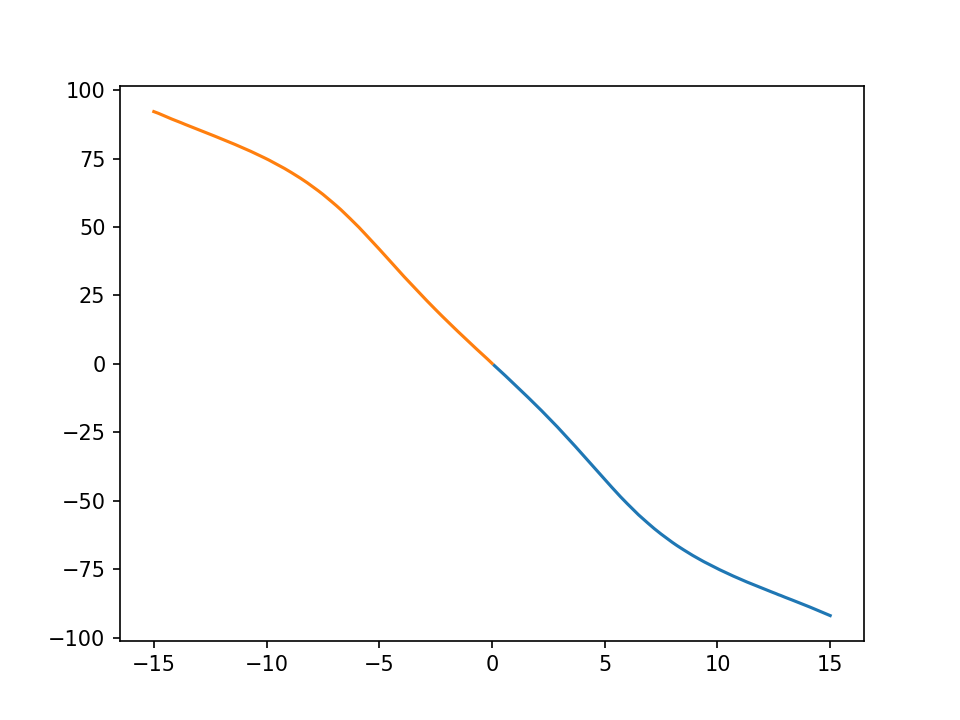

In [91]:
plt.plot(vp_rp.R, vp_rp.theta)
plt.plot(vp_rn.R, vp_rn.theta)

### Positive and Negative field discrepancy is <0.5$^\circ$ 

<IPython.core.display.Javascript object>


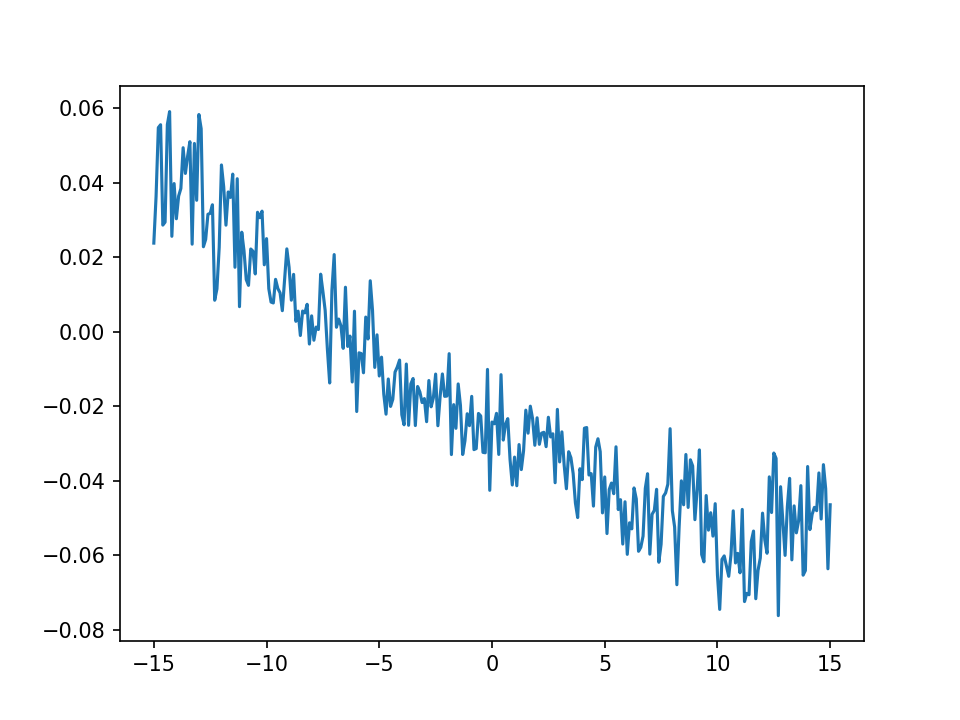

In [92]:
plt.plot(vp.R, (vp.theta+vn.theta))

### Positive voltage R-theta relation

In [93]:
vp_R_thetapos_coeff = np.polyfit(vp_rp.theta, vp_rp.R, 6)
vp_R_thetaneg_coeff = np.polyfit(vp_rn.theta, vp_rn.R, 6)
vp_R_thetapos = np.poly1d(vp_R_thetapos_coeff)
vp_R_thetaneg = np.poly1d(vp_R_thetaneg_coeff)
R_theta = vp_R_thetapos_coeff,vp_R_thetaneg_coeff
print(R_theta)
np.savetxt("./icarusCalibCsv/icarus_radial_polar_calib.csv", R_theta, delimiter=",")

(array([-1.94073973e-10, -4.84340113e-08, -4.28111659e-06, -1.77582646e-04,
       -3.88923105e-03, -1.61647836e-01, -3.26154706e-02]), array([ 1.76091508e-10, -4.39138524e-08,  3.84152771e-06, -1.55574827e-04,
        3.30721453e-03, -1.56966347e-01,  7.21176746e-02]))


<IPython.core.display.Javascript object>


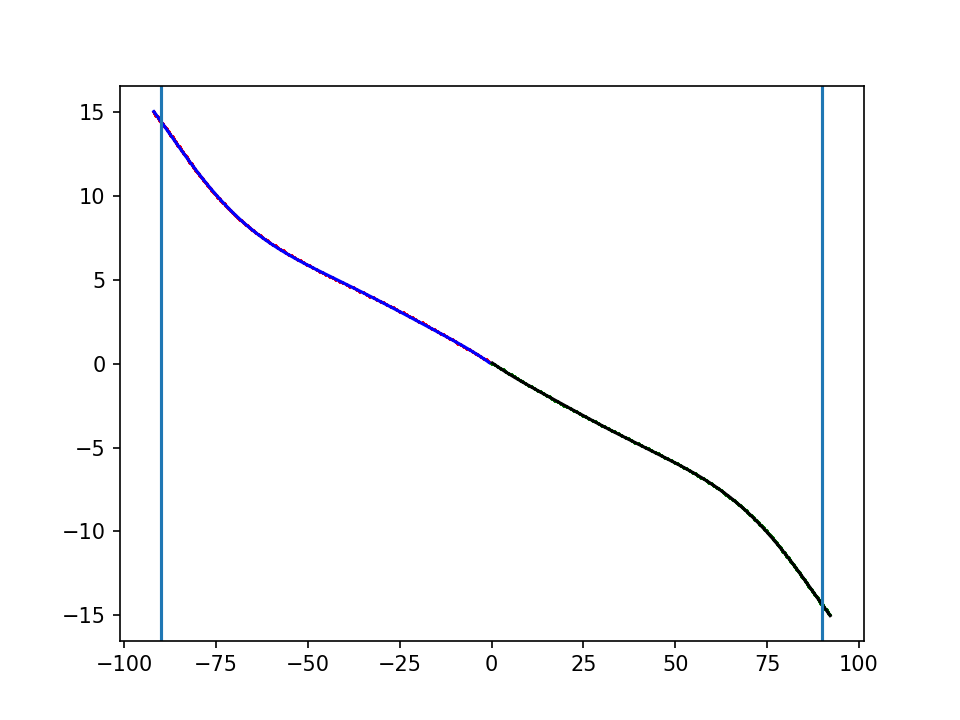

In [95]:
plt.figure(dpi=100)
plt.plot(vp_rp.theta, vp_rp.R, 'r+', markersize=2)
plt.plot(vp_rp.theta, vp_R_thetapos(vp_rp.theta), 'b')
plt.plot(vp_rn.theta, vp_rn.R, 'g+', markersize=2)
plt.plot(vp_rn.theta, vp_R_thetaneg(vp_rn.theta), 'k')
plt.axvline(90)
plt.axvline(-90)

In [96]:
bmag_vp_rp_coeff = np.polyfit(vp[vp.R>0].R, vp[vp.R>0].Bmag, 10)
bmag_vp_rp = np.poly1d(bmag_vp_rp_coeff)

bmag_vp_rn_coeff = np.polyfit(vp[vp.R<0].R, vp[vp.R<0].Bmag, 10)
bmag_vp_rn = np.poly1d(bmag_vp_rn_coeff)

bmag_vn_rp_coeff = np.polyfit(vn[vn.R>0].R, vn[vn.R>0].Bmag, 10)
bmag_vn_rp = np.poly1d(bmag_vn_rp_coeff)

bmag_vn_rn_coeff = np.polyfit(vn[vn.R<0].R, vn[vn.R<0].Bmag, 10)
bmag_vn_rn = np.poly1d(bmag_vn_rn_coeff)

<IPython.core.display.Javascript object>


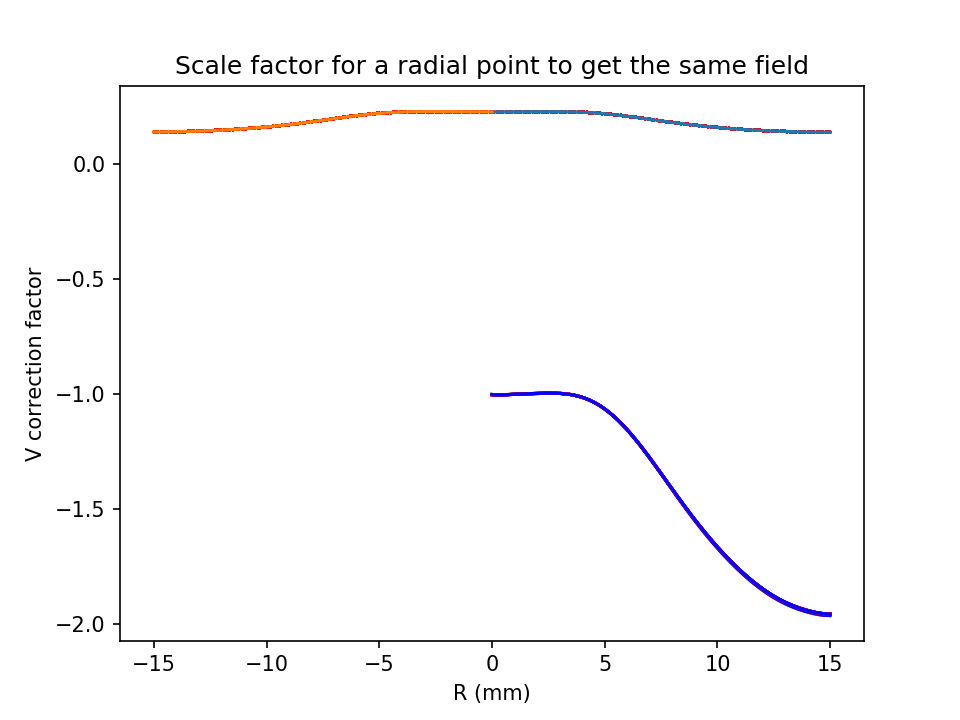

In [97]:
plt.figure(dpi=100)
plt.plot(vp.R, vp.Bmag, 'r+', markersize=2)
plt.plot(vp[vp.R>0].R, bmag_vp_rp(vp[vp.R>0].R))
plt.plot(vp[vp.R<0].R, bmag_vp_rn(vp[vp.R<0].R))
# plt.plot(vn.R, vn.Bmag, 'g+', markersize=2)
# plt.plot(vn[vn.R>0].R, bmag_vn_rp(vn[vn.R>0].R))
# plt.plot(vn[vn.R<0].R, bmag_vn_rn(vn[vn.R<0].R))

<IPython.core.display.Javascript object>


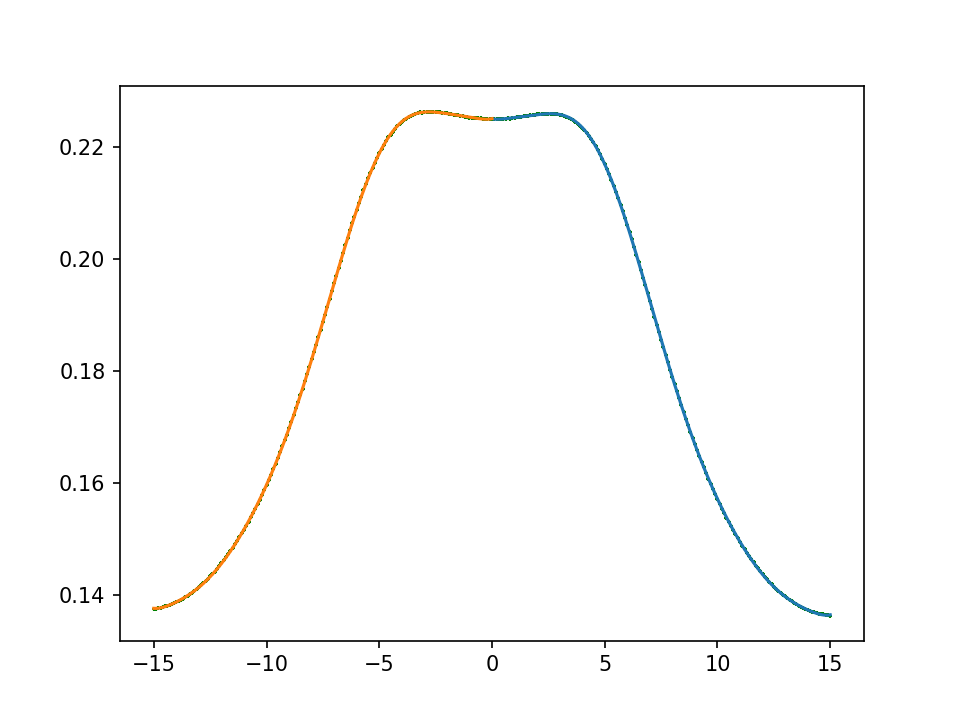

In [98]:
plt.figure(dpi=100)
plt.plot(vn.R, vn.Bmag, 'g+', markersize=2)
plt.plot(vn[vn.R>0].R, bmag_vn_rp(vn[vn.R>0].R))
plt.plot(vn[vn.R<0].R, bmag_vn_rn(vn[vn.R<0].R))

### Voltage Correction function

In [99]:
V0 = 5.0 # Voltage used for radial scan
Rpts_p = np.arange(0, 15, 0.01)
Rpts_n = np.arange(-15, 0, 0.01)

In [112]:
vcent_vp_rp = -V0/cen_vp_fit(bmag_vp_rp(Rpts_p))
vcent_vp_rn = -V0/cen_vp_fit(bmag_vp_rn(Rpts_n))
vcent_vn_rp = V0/cen_vn_fit(-bmag_vn_rp(Rpts_p))
vcent_vn_rn = V0/cen_vn_fit(-bmag_vn_rn(Rpts_n))

In [113]:
n = 10
vcorr_vp_rp_coeff = np.polyfit(Rpts_p, vcent_vp_rp, n)
vcorr_vp_rp = np.poly1d(vcorr_vp_rp_coeff)
vcorr_vp_rn_coeff = np.polyfit(Rpts_n, vcent_vp_rn, n)
vcorr_vp_rn = np.poly1d(vcorr_vp_rn_coeff)
vcorr_vn_rp_coeff = np.polyfit(Rpts_p, vcent_vn_rp, n)
vcorr_vn_rp = np.poly1d(vcorr_vn_rp_coeff)
vcorr_vn_rn_coeff = np.polyfit(Rpts_n, vcent_vn_rn, n)
vcorr_vn_rn = np.poly1d(vcorr_vn_rn_coeff)

In [114]:
print(vcorr_vp_rp_coeff, '\n', vcorr_vp_rn_coeff, '\n', vcorr_vn_rp_coeff, '\n',vcorr_vn_rn_coeff)

[-9.95526852e-10  7.80010391e-08 -2.57829438e-06  4.64758149e-05
 -4.92149115e-04  3.07338951e-03 -1.09765243e-02  2.28181771e-02
 -2.66841401e-02  1.13851368e-02  1.00319216e+00] 
 [-9.01175695e-10 -7.19660114e-08 -2.42979003e-06 -4.48560805e-05
 -4.88146035e-04 -3.14739305e-03 -1.16575778e-02 -2.48887424e-02
 -2.92747549e-02 -1.18690276e-02  1.00324909e+00] 
 [-9.84076387e-10  7.73684915e-08 -2.56629638e-06  4.64192381e-05
 -4.93179236e-04  3.08912139e-03 -1.10579994e-02  2.29831581e-02
 -2.66969438e-02  1.11405179e-02  1.00302190e+00] 
 [-8.30367839e-10 -6.71393005e-08 -2.29329758e-06 -4.27929712e-05
 -4.70304282e-04 -3.06062876e-03 -1.14509191e-02 -2.48034843e-02
 -2.97559119e-02 -1.23886880e-02  1.00280868e+00]


In [115]:
vcorr_coeffs = [vcorr_vp_rp_coeff, vcorr_vn_rp_coeff, vcorr_vp_rn_coeff, vcorr_vn_rn_coeff]
np.savetxt("./icarusCalibCsv/icarus_volt_correction_calib.csv", vcorr_coeffs, delimiter=",")

Text(0.5, 1.0, 'Scale factor for a radial point to get the same field')

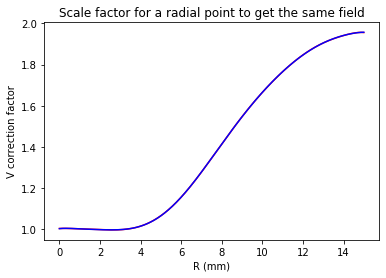

In [116]:
plt.plot(Rpts_p, vcent_vp_rp, 'r', markersize = 2)
plt.plot(Rpts_p, vcorr_vp_rp(Rpts_p), 'b')
plt.xlabel('R (mm)')
plt.ylabel('V correction factor')
plt.title('Scale factor for a radial point to get the same field')

Text(0.5, 1.0, 'Scale factor for a radial point to get the same field')

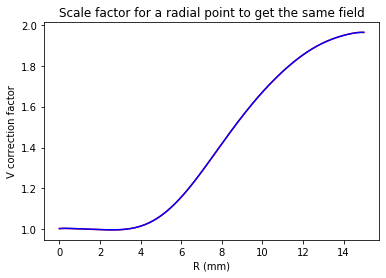

In [117]:
plt.plot(Rpts_p, vcent_vn_rp, 'r', markersize = 2)
plt.plot(Rpts_p, vcorr_vn_rp(Rpts_p), 'b')
plt.xlabel('R (mm)')
plt.ylabel('V correction factor')
plt.title('Scale factor for a radial point to get the same field')